In [21]:
import numpy as np # linear algebra
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time
%matplotlib inline
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split

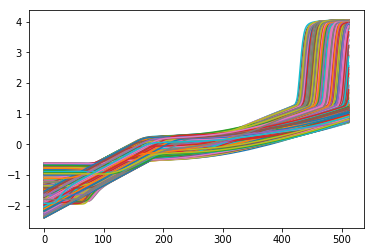

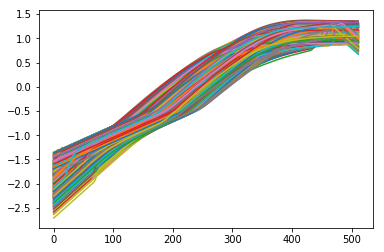

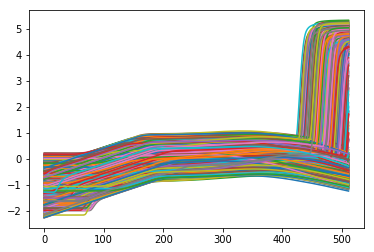

(800, 512, 3) (800, 3) (200, 512, 3) (200, 3)


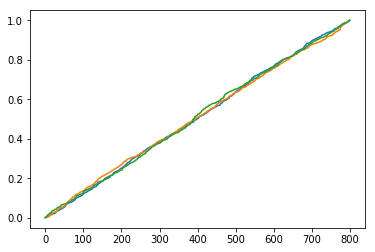

In [22]:
X=np.loadtxt('X.csv',delimiter=',')
Y=np.loadtxt('Y.csv',delimiter=',')

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

x_train=np.reshape(x_train,(-1,512,3))
x_test=np.reshape(x_test,(-1,512,3))

for i in range(3):
    mean=np.mean(x_train[:,:,i])
    std=np.std(x_train[:,:,i])
    x_train[:,:,i]=(x_train[:,:,i]-mean)/std
    x_test[:,:,i]=(x_test[:,:,i]-mean)/std
#x_train=np.expand_dims(x_train, axis=2)
#x_test=np.expand_dims(x_test, axis=2)

plt.plot(np.transpose(x_train[:,:,0]))
plt.show()
plt.plot(np.transpose(x_train[:,:,1]))
plt.show()
plt.plot(np.transpose(x_train[:,:,2]))
plt.show()

y_train=np.log10(y_train)
y_test=np.log10(y_test)
y_train[:,1]=y_train[:,1]+1
y_test[:,1]=y_test[:,1]+1
y_train[:,2]=y_train[:,2]/2
y_test[:,2]=y_test[:,2]/2
'''max=np.max(y_train,axis=0)
y_train=y_train/max
y_test=y_test/max'''
for i in range(3):
    plt.plot(np.sort(y_train[:,i]))

print(np.shape(x_train),np.shape(y_train),np.shape(x_test),np.shape(y_test))

/home/vinit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


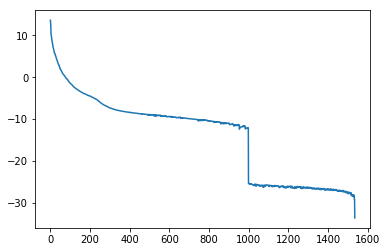

(1000, 3)


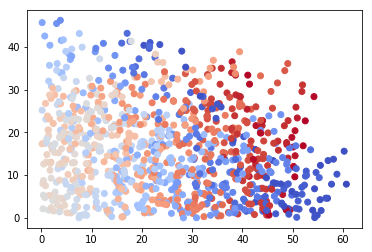

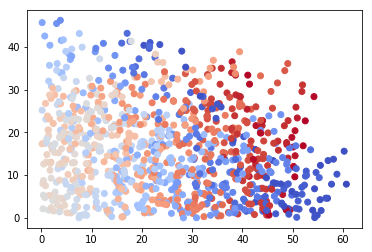

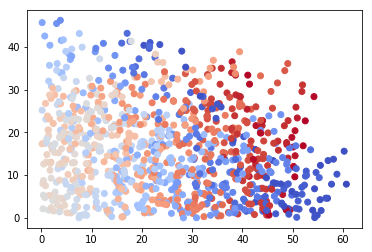

'\nax = plt.figure().add_subplot(111, projection=\'3d\')\nax.scatter(Z[:,0],Z[:,1],Z[:,2], c=y_train[:,0], cmap="coolwarm")\n#plt.savefig(\'Sigma_PCA.png\')\nplt.show()\n\nax = plt.figure().add_subplot(111, projection=\'3d\')\nax.scatter(Z[:,0],Z[:,1], c=y_train[:,1], cmap="coolwarm")\n#plt.savefig(\'Eth_PCA.png\')\nplt.show()\n\nax = plt.figure().add_subplot(111, projection=\'3d\')\nax.scatter(Z[:,1],Z[:,2], c=y_train[:,2], cmap="coolwarm")\n#plt.savefig(\'Slope_PCA.png\')\nplt.show()\n'

In [5]:
#Data Analysis
X = np.reshape(np.transpose(x_train,(0,2,1)),(-1,512*3))
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
X_=np.matrix.transpose(X)

lambd,W=np.linalg.eig(np.matmul(X_,X))

plt.plot(np.log(lambd))
plt.show()

Z=np.abs(np.matmul(X,W[:,:3]))
print(np.shape(Z))

for i in range(3):
    plt.scatter(Z[:,0],Z[:,1], c=y_train[:,0], cmap="coolwarm")
    plt.show()

'''
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(Z[:,0],Z[:,1],Z[:,2], c=y_train[:,0], cmap="coolwarm")
#plt.savefig('Sigma_PCA.png')
plt.show()

ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(Z[:,0],Z[:,1], c=y_train[:,1], cmap="coolwarm")
#plt.savefig('Eth_PCA.png')
plt.show()

ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(Z[:,1],Z[:,2], c=y_train[:,2], cmap="coolwarm")
#plt.savefig('Slope_PCA.png')
plt.show()
'''

In [10]:
model = Sequential()

model.add(Flatten(input_shape=(512,3)))
model.add(Dense(2048, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(4046, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(2048, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(3, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              3147776   
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 4046)              8290254   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4046)              0         
__________

In [16]:
model.compile(loss='mean_squared_error', optimizer = Adam(lr=1e-4), metrics=["accuracy"]) #binary_crossentropy

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

hist = model.fit(x=x_train, y=y_train, batch_size=512,
                           epochs=20, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_test, y_test), #For speed
                           callbacks=[annealer])

Train on 1000 samples, validate on 250 samples
Epoch 1/20
 - 4s - loss: 0.0314 - acc: 0.7970 - val_loss: 0.0881 - val_acc: 0.8080
Epoch 2/20
 - 1s - loss: 0.0539 - acc: 0.7750 - val_loss: 0.0679 - val_acc: 0.7400
Epoch 3/20
 - 1s - loss: 0.0445 - acc: 0.7500 - val_loss: 0.0591 - val_acc: 0.7800
Epoch 4/20
 - 1s - loss: 0.0348 - acc: 0.7570 - val_loss: 0.0592 - val_acc: 0.7480
Epoch 5/20
 - 1s - loss: 0.0273 - acc: 0.7520 - val_loss: 0.0497 - val_acc: 0.7160
Epoch 6/20
 - 1s - loss: 0.0248 - acc: 0.7680 - val_loss: 0.0358 - val_acc: 0.7560
Epoch 7/20
 - 1s - loss: 0.0204 - acc: 0.7760 - val_loss: 0.0383 - val_acc: 0.7480
Epoch 8/20
 - 1s - loss: 0.0192 - acc: 0.7800 - val_loss: 0.0336 - val_acc: 0.7600
Epoch 9/20
 - 1s - loss: 0.0172 - acc: 0.7730 - val_loss: 0.0309 - val_acc: 0.7440
Epoch 10/20
 - 1s - loss: 0.0162 - acc: 0.7750 - val_loss: 0.0266 - val_acc: 0.7640
Epoch 11/20
 - 1s - loss: 0.0146 - acc: 0.7870 - val_loss: 0.0210 - val_acc: 0.7480
Epoch 12/20
 - 1s - loss: 0.0143 - acc

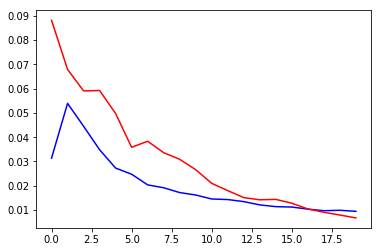

In [17]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()

In [18]:
model.evaluate(x_test, y_test)

250/250 [==============================] - 0s 479us/step


[0.006764593783766031, 0.8599999980926514]

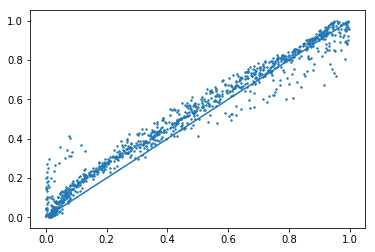

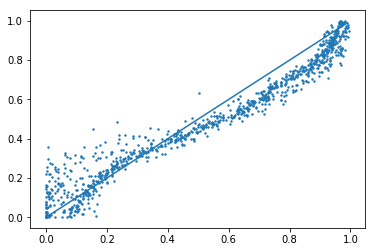

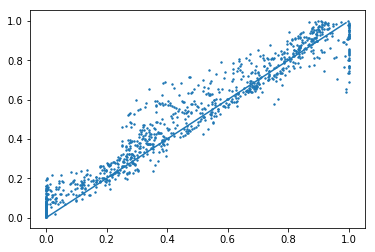

In [19]:
for i in range(3):
    plt.scatter(model.predict(x_train)[:,i],y_train[:,i],s=2)
    plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01))
    plt.show()

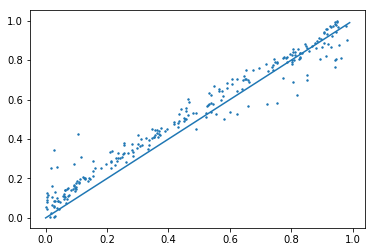

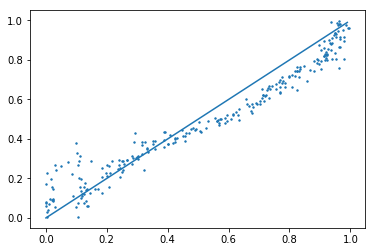

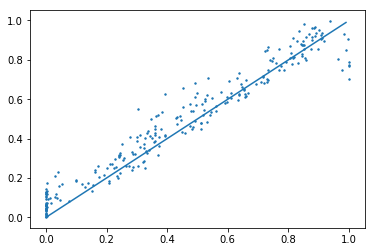

In [20]:
for i in range(3):
    plt.scatter(model.predict(x_test)[:,i],y_test[:,i],s=2)
    plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01))
    plt.show()